In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data_avg = pd.read_csv("/content/drive/MyDrive/data_avg.csv")

In [ ]:
data_avg

,Pixel_ID,Timestep,Date,NDVI,Rainfall,Temperature,DEM
0,0,1,2018-10-17,0.268060,6.2,17.0,217.827846
1,0,2,2018-10-22,0.268060,3.2,17.6,217.827846
2,0,3,2018-10-27,0.281899,0.4,16.8,217.827846
3,0,4,2018-11-01,0.357905,5.2,10.6,217.827846
4,0,5,2018-11-06,0.362010,4.0,13.6,217.827846
...,...,...,...,...,...,...,...
615385,23697,26,2019-10-26,0.332526,2.4,9.4,15.228439
615386,23697,27,2019-10-31,0.321064,0.6,3.0,15.228439
615387,23697,28,2019-11-05,0.317333,0.0,2.8,15.228439
615388,23697,29,2019-11-10,0.320930,2.2,2.2,15.228439


In [ ]:
data_avg.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pixel_ID,615390.0,11575.089504,6916.125703,0.000000,5603.000000,11434.000000,17503.000000,23697.000000
Timestep,615390.0,15.500000,8.655448,1.000000,8.000000,15.500000,23.000000,30.000000
NDVI,615390.0,0.538839,0.211279,-0.995942,0.378456,0.561304,0.707849,0.999615
Rainfall,615390.0,1.337114,2.359941,0.000000,0.000000,0.000000,1.800000,65.400000
Temperature,615390.0,16.113640,6.170675,-10.200000,11.200000,16.200000,21.000000,33.000000
DEM,615390.0,330.375438,284.567277,-2.468250,126.307393,241.645991,424.974665,2200.214172


# 1. Split and normalize the data

In [ ]:
#Split the data in 70% training, 20% validation and 10% testing
from sklearn.model_selection import train_test_split

pixel_ids = data_avg['Pixel_ID'].unique()

# Randomly shuffle the pixel_ids
np.random.shuffle(pixel_ids)

split_idx_1 = int(0.7 * len(pixel_ids))
split_idx_2 = int(0.9 * len(pixel_ids))  

train_pixel_ids = pixel_ids[:split_idx_1]
val_pixel_ids = pixel_ids[split_idx_1:split_idx_2]
test_pixel_ids = pixel_ids[split_idx_2:]

train = data_avg.loc[data_avg['Pixel_ID'].isin(train_pixel_ids)]
val = data_avg.loc[data_avg['Pixel_ID'].isin(val_pixel_ids)]
test = data_avg.loc[data_avg['Pixel_ID'].isin(test_pixel_ids)]

In [ ]:
# Normalization use minmaxscaler

from sklearn.preprocessing import MinMaxScaler

# Create the RobustScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
ndvi_dem_rain_temp_train = train[['NDVI','DEM','Rainfall', 'Temperature']].copy()
ndvi_dem_rain_temp_train_scaled = scaler.fit_transform(ndvi_dem_rain_temp_train)
train_scaled_avg = pd.concat([train, pd.DataFrame(ndvi_dem_rain_temp_train_scaled, columns=['NDVI_scaled', 'DEM_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_dem_rain_temp_train.index)], axis=1)

# Transform the validation data using the same scaler
ndvi_dem_rain_temp_val = val[['NDVI','DEM', 'Rainfall', 'Temperature']].copy()
ndvi_dem_rain_temp_val_scaled = scaler.transform(ndvi_dem_rain_temp_val)
val_scaled_avg = pd.concat([val, pd.DataFrame(ndvi_dem_rain_temp_val_scaled, columns=['NDVI_scaled', 'DEM_scaled','Rainfall_scaled', 'Temperature_scaled'], index=ndvi_dem_rain_temp_val.index)], axis=1)

# Transform the testing data using the same scaler
ndvi_dem_rain_temp_test = test[['NDVI','DEM', 'Rainfall', 'Temperature']].copy()
ndvi_dem_rain_temp_test_scaled = scaler.transform(ndvi_dem_rain_temp_test)
test_scaled_avg = pd.concat([test, pd.DataFrame(ndvi_dem_rain_temp_test_scaled, columns=['NDVI_scaled','DEM_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_dem_rain_temp_test.index)], axis=1)


In [ ]:
train_scaled_avg

,Pixel_ID,Timestep,Date,NDVI,Rainfall,Temperature,DEM,NDVI_scaled,DEM_scaled,Rainfall_scaled,Temperature_scaled
0,0,1,2018-10-17,0.268060,6.2,17.0,217.827846,0.632980,0.100013,0.094801,0.629630
1,0,2,2018-10-22,0.268060,3.2,17.6,217.827846,0.632980,0.100013,0.048930,0.643519
2,0,3,2018-10-27,0.281899,0.4,16.8,217.827846,0.639923,0.100013,0.006116,0.625000
3,0,4,2018-11-01,0.357905,5.2,10.6,217.827846,0.678056,0.100013,0.079511,0.481481
4,0,5,2018-11-06,0.362010,4.0,13.6,217.827846,0.680115,0.100013,0.061162,0.550926
...,...,...,...,...,...,...,...,...,...,...,...
615355,23694,26,2019-10-06,0.584185,1.8,4.8,29.283722,0.791580,0.014415,0.027523,0.347222
615356,23694,27,2019-10-11,0.395411,0.4,6.8,29.283722,0.696872,0.014415,0.006116,0.393519
615357,23694,28,2019-10-16,0.395703,3.4,9.0,29.283722,0.697019,0.014415,0.051988,0.444444
615358,23694,29,2019-10-21,0.396565,2.2,9.2,29.283722,0.697451,0.014415,0.033639,0.449074


In [ ]:
train_scaled_avg.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pixel_ID,430770.0,11578.318964,6899.874287,0.000000,5616.000000,11501.000000,17499.000000,23694.000000
Timestep,430770.0,15.500000,8.655451,1.000000,8.000000,15.500000,23.000000,30.000000
NDVI,430770.0,0.538506,0.211035,-0.993617,0.377142,0.560614,0.707701,0.999615
Rainfall,430770.0,1.336794,2.366823,0.000000,0.000000,0.000000,1.800000,65.400000
Temperature,430770.0,16.088071,6.168097,-10.200000,11.200000,16.200000,21.000000,33.000000
DEM,430770.0,329.742046,283.964736,-2.468250,125.838077,240.770230,423.909858,2200.214172
NDVI_scaled,430770.0,0.768662,0.105876,0.000000,0.687706,0.779754,0.853547,1.000000
DEM_scaled,430770.0,0.150821,0.128918,0.000000,0.058250,0.110428,0.193572,1.000000
Rainfall_scaled,430770.0,0.020440,0.036190,0.000000,0.000000,0.000000,0.027523,1.000000
Temperature_scaled,430770.0,0.608520,0.142780,0.000000,0.495370,0.611111,0.722222,1.000000


In [ ]:
# Check for NaN values in the scaled input features
has_nan = train_scaled_avg.isna().any().any()
print("NaN values in the scaled input features:", has_nan)

NaN values in the scaled input features: False


# 2. Build data structure for train the model

In [ ]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1,l2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K
import joblib
from keras.models import load_model
import time

In [ ]:
# Select input and output variables
input_vars = ['NDVI_scaled','DEM_scaled', 'Rainfall_scaled', 'Temperature_scaled']
output_var = 'NDVI_scaled'

# Define window size for input sequences
window_size = 20

# Create sequences of input and output for training data
X_train_avg = []
y_train_avg = []
for pixel_id in train_scaled_avg['Pixel_ID'].unique():
    pixel_data = train_scaled_avg[train_scaled_avg['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_train_avg.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_train_avg.append(pixel_data.loc[i, output_var])

# Create sequences of input and output for validation data
X_val_avg = []
y_val_avg = []
for pixel_id in val_scaled_avg['Pixel_ID'].unique():
    pixel_data = val_scaled_avg[val_scaled_avg['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_val_avg.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_val_avg.append(pixel_data.loc[i, output_var])

# Create sequences of input and output for testing data
X_test_avg = []
y_test_avg = []
for pixel_id in test_scaled_avg['Pixel_ID'].unique():
    pixel_data = test_scaled_avg[test_scaled_avg['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_test_avg.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_test_avg.append(pixel_data.loc[i, output_var])

# Convert X and y to numpy arrays
X_train_avg = np.array(X_train_avg)
y_train_avg = np.array(y_train_avg)
X_val_avg = np.array(X_val_avg)
y_val_avg = np.array(y_val_avg)
X_test_avg = np.array(X_test_avg)
y_test_avg = np.array(y_test_avg)

In [ ]:
X_test_avg_reshaped = pd.DataFrame(X_test_avg.reshape(X_test_avg.shape[0], -1))
X_test_avg_reshaped.shape

(20520, 80)

## 2.1 Random forest model

In [ ]:
# Train the Random Forest model with increased n_estimators and max_depth
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
# Start recording training time
start_time_rf = time.time()

In [ ]:
rf_model.fit(X_train_avg.reshape((X_train_avg.shape[0], -1)), y_train_avg)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

In [ ]:
# Calculate the training time
training_time_rf = time.time() - start_time_rf
print("Training time: ", training_time_rf, "seconds")

In [ ]:
# Evaluate the model on the test set
rf_test_flat = X_test_avg.reshape(X_test_avg.shape[0], -1)

rf_mse = mean_squared_error(y_test_avg, rf_model.predict(rf_test_flat))
print("Random forest MSE:", rf_mse)

Random forest MSE: 0.0013841213690987551


In [ ]:
# Save the model
joblib.dump(rf_model, "/content/drive/MyDrive/Saved_models/rf_model_avg.pkl")

['/content/drive/MyDrive/Saved_models/rf_model_avg.pkl']

In [ ]:
# Load rf model
rf_model = joblib.load("/content/drive/MyDrive/Saved_models/rf_model_avg.pkl")

In [ ]:
# Predict the NDVI values using the Random Forest model
rf_pred_test = rf_model.predict(X_test_avg.reshape((X_test_avg.shape[0], -1)))

# Inverse transform the predicted NDVI values
#inverse_rf_pred_test = scaler.inverse_transform(np.hstack([rf_pred_test.reshape(-1, 1), np.zeros((rf_pred_test.shape[0], 2))]))[:, 0]

rf_pred_test.shape

(20520,)

In [ ]:

# Inverse transform the predicted NDVI values
# rf_inverse_y_pred_test = scaler.inverse_transform(np.hstack([rf_pred_test.reshape(-1, 1), np.zeros((rf_pred_test.shape[0], 2))]))[:, 0]


[0.75378738 0.74642369 0.73363027 ... 0.32096486 0.31442708 0.32181357]


,count,mean,std,min,25%,50%,75%,max
0,20520.0,0.560223,0.175878,-0.752662,0.440023,0.571023,0.700453,0.886475


## 2.2 LSTM model

In [ ]:
# from keras.callbacks import EarlyStopping
# from keras.regularizers import L1L2

# # Define the LSTM model architecture
# lstm_model = Sequential()
# lstm_model.add(LSTM(128, input_shape=(window_size, len(input_vars)), activation='tanh', kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
# lstm_model.add(Dense(1))
# lstm_model.compile(loss="MSE", optimizer='adam')

# # Set up early stopping callback with increased patience
# early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


In [ ]:

from keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
from keras.optimizers import Adam

learning_rate = 0.0001
# Define the LSTM model architecture
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(window_size, len(input_vars)), activation='tanh', kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(32, activation='relu')) 
lstm_model.add(Dense(1))

# Compile the model with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)
lstm_model.compile(loss="MSE", optimizer=optimizer)
# Set up early stopping callback with increased patience
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Start recording training time
start_time_lstm = time.time()

In [ ]:
# Train the model
lstm_history = lstm_model.fit(
    X_train_avg, y_train_avg,
    epochs=100,  
    batch_size=60,
    validation_data=(X_val_avg, y_val_avg),
    callbacks=[early_stop]
)

In [ ]:
# Calculate the training time
training_time_lstm = time.time() - start_time_lstm
print("Training time: ", training_time_lstm, "seconds")

Training time:  965.8092558383942 seconds


In [ ]:
# Evaluate the model on the test set
lstm_mse = mean_squared_error(y_test_avg, lstm_model.predict(X_test_avg))
print("LSTM MSE:", lstm_mse)

642/642 [==============================] - 1s 2ms/step
LSTM MSE: 0.0017457909761214858


In [ ]:
lstm_model.save("/content/drive/MyDrive/Saved_models/lstm_model_avg")

In [ ]:
# Load lstm model
lstm_model = load_model("/content/drive/MyDrive/Saved_models/lstm_model_avg")

In [ ]:
# Predict the NDVI values 
lstm_pred_test = lstm_model.predict(X_test_avg)

# Inverse transform the predicted NDVI values
# lstm_inverse_y_pred_test = scaler.inverse_transform(np.hstack([lstm_pred_test.reshape(-1, 1), np.zeros((lstm_pred_test.shape[0], 2))]))[:, 0]

lstm_pred_test.shape

642/642 [==============================] - 1s 2ms/step


(20520, 1)

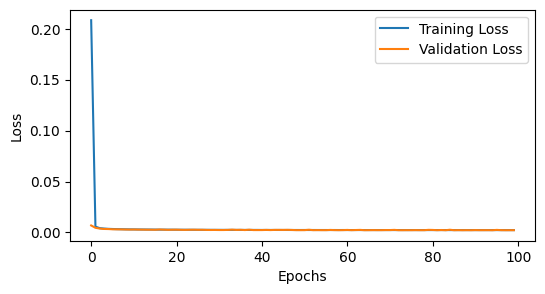

In [ ]:
# Plot training and validation loss for LSTM
plt.figure(figsize=(6, 3))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
print("X_train shape:", np.shape(X_train_avg))
print("X_val shape:", np.shape(X_val_avg))
print("X_test shape:", np.shape(X_test_avg))
print("y_train shape:", np.shape(y_train_avg))
print("y_val shape:", np.shape(y_val_avg))
print("y_test shape:", np.shape(y_test_avg))

X_train shape: (143590, 20, 4)
X_val shape: (41020, 20, 4)
X_test shape: (20520, 20, 4)
y_train shape: (143590,)
y_val shape: (41020,)
y_test shape: (20520,)


## 2.3 convLSTM

In [ ]:
# convLSTM
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Flatten

# Define the model architecture
convlstm_model = Sequential()
convlstm_model.add(ConvLSTM2D(filters=32, kernel_size=(3,3), input_shape=(window_size, 1, 1, len(input_vars)), padding='same', return_sequences=True))
convlstm_model.add(Dropout(0.2))
convlstm_model.add(ConvLSTM2D(filters=16, kernel_size=(3,3), padding='same', return_sequences=False))
convlstm_model.add(Dropout(0.2))
convlstm_model.add(Flatten())
convlstm_model.add(Dense(1))

convlstm_model.compile(loss='mse', optimizer='adam')

In [ ]:
# Reshape the input data to match ConvLSTM2D's input shape: (samples, time_steps, height, width, channels)
X_train_reshaped = X_train.reshape((X_train.shape[0], window_size, 1, 1, len(input_vars)))
X_val_reshaped = X_val.reshape((X_val.shape[0], window_size, 1, 1, len(input_vars)))
X_test_reshaped = X_test.reshape((X_test.shape[0], window_size, 1, 1, len(input_vars)))

# Set up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
convlstm_history = convlstm_model.fit(X_train_reshaped, y_train, epochs=30, validation_data=(X_val_reshaped, y_val), callbacks=[early_stop])

In [ ]:
# Evaluate the model on the test set
convlstm_mse = mean_squared_error(y_test, convlstm_model.predict(X_test_reshaped))
print("convLSTM Mean Squared Error:", convlstm_mse)

642/642 [==============================] - 13s 20ms/step
convLSTM Mean Squared Error: 0.03740329363792658


In [ ]:
# save model
convlstm_model.save("/content/drive/MyDrive/Saved_models/convlstm_model_avg")

In [ ]:
# Load convlstm model
convlstm_model = load_model("/content/drive/MyDrive/Saved_models/convlstm_model_avg")

## 2.4 Transformer

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, TimeDistributed
from tensorflow.keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling1D, AveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import layers, Model


In [ ]:
# Positional encoding for the transformer model
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Multi-head attention
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

# Transformer Encoder Layer
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# Transformer Encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = layers.Dense(self.d_model, activation='linear')
        self.pos_encoding = positional_encoding(input_shape[0], self.d_model)
        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

def create_simplified_transformer_model(input_shape, num_layers, d_model, num_heads, dff, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    mask = None
    x = TransformerEncoder(num_layers, d_model, num_heads, dff, input_shape, rate)(inputs, training=None, mask=mask)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (window_size, len(input_vars))
num_layers = 1
d_model = 32
num_heads = 2
dff = 64
dropout_rate = 0.1

transformer_model = create_simplified_transformer_model(input_shape, num_layers, d_model, num_heads, dff, dropout_rate)
transformer_model.summary()

transformer_model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 3)]           0         
                                                                 
 transformer_encoder (Transf  (None, 20, 32)           8672      
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable par

In [ ]:
history = transformer_model.fit(X_train, y_train, epochs=100, batch_size=64,
                                           validation_data=(X_val, y_val)
                                           )
#callbacks=[early_stop]

In [ ]:
# Evaluate the model on the test set
transformer_mse = mean_squared_error(y_test, transformer_model.predict(X_test))
print("Transformer Mean Squared Error:", transformer_mse)

642/642 [==============================] - 2s 3ms/step
Transformer Mean Squared Error: 0.040382969958547656


In [ ]:
# save model
transformer_model.save("/content/drive/MyDrive/Saved_models/transformer_model_avg")

In [ ]:
# Load transformer model
transformer_model = load_model("/content/drive/MyDrive/Saved_models/transformer_model_avg")

# 3. Compare the model performance

In [ ]:
# Load models
rf_model = joblib.load("/content/drive/MyDrive/Saved_models/rf_model_avg.pkl")
lstm_model = load_model("/content/drive/MyDrive/Saved_models/lstm_model_avg")


In [ ]:
# predicted NDVI values for rf, LSTM,convLSTM,transformer model
#test

# Predict the NDVI values using the Random Forest model
rf_pred_test = rf_model.predict(X_test_avg.reshape((X_test_avg.shape[0], -1)))
lstm_pred_test = lstm_model.predict(X_test_avg)

#val
rf_pred_val = rf_model.predict(X_val_avg.reshape((X_val_avg.shape[0], -1)))
lstm_pred_val = lstm_model.predict(X_val_avg)


1282/1282 [==============================] - 2s 2ms/step


In [ ]:
# Compare the model performance by scatter plot of predicted and expected NDVI

# Inverse transform the true NDVI values for the test set
inverse_y_test_avg = scaler.inverse_transform(np.hstack([y_test_avg.reshape(-1, 1), np.zeros((y_test_avg.shape[0], 3))]))[:, 0]
# Inverse transform the true NDVI values for the validation set
inverse_y_val_avg = scaler.inverse_transform(np.hstack([y_val_avg.reshape(-1, 1), np.zeros((y_val_avg.shape[0], 3))]))[:, 0]

# Inverse transform the predicted NDVI test values for 4 models
rf_inverse_y_pred_test = scaler.inverse_transform(np.hstack([rf_pred_test.reshape(-1, 1), np.zeros((rf_pred_test.shape[0], 3))]))[:, 0]
lstm_inverse_y_pred_test = scaler.inverse_transform(np.hstack([lstm_pred_test, np.zeros((lstm_pred_test.shape[0], 3))]))[:, 0]

# Inverse transform the predicted NDVI validation values for 4 models
rf_inverse_y_pred_val = scaler.inverse_transform(np.hstack([rf_pred_val.reshape(-1, 1), np.zeros((rf_pred_val.shape[0], 3))]))[:, 0]
lstm_inverse_y_pred_val = scaler.inverse_transform(np.hstack([lstm_pred_val, np.zeros((lstm_pred_val.shape[0], 3))]))[:, 0]


# Calculate MSE for each model on testing set
mse_rf_val = mean_squared_error(inverse_y_val_avg, rf_inverse_y_pred_val)
mse_lstm_val = mean_squared_error(inverse_y_val_avg, lstm_inverse_y_pred_val)

# Calculate MSE for each model on testing set
mse_rf_test = mean_squared_error(inverse_y_test_avg, rf_inverse_y_pred_test)
mse_lstm_test = mean_squared_error(inverse_y_test_avg, lstm_inverse_y_pred_test)

# Calculate R2 scores for the test set
r2_rf_test = r2_score(inverse_y_test_avg, rf_inverse_y_pred_test)
r2_lstm_test = r2_score(inverse_y_test_avg, lstm_inverse_y_pred_test)

# Calculate RMSE scores for the test set
rmse_rf_test = np.sqrt(mean_squared_error(inverse_y_test_avg, rf_inverse_y_pred_test))
rmse_lstm_test = np.sqrt(mean_squared_error(inverse_y_test_avg, lstm_inverse_y_pred_test))


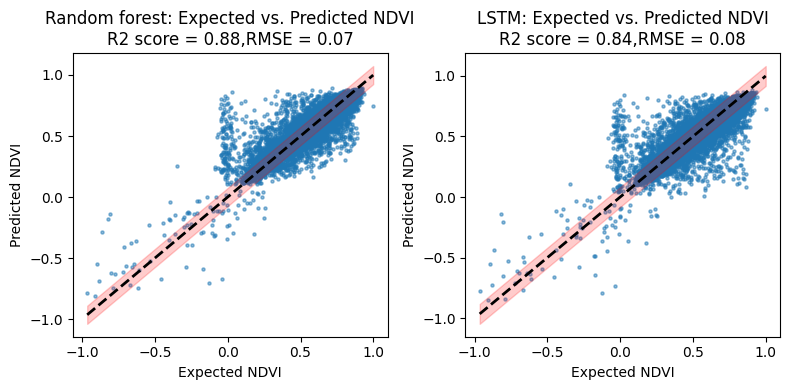

In [ ]:
# Create a 2x2 grid of subplots for the 4 different models
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Set titles and labels
titles = ['Random forest', 'LSTM']
predictions = [rf_inverse_y_pred_test, lstm_inverse_y_pred_test]
r2_scores = [r2_rf_test, r2_lstm_test]
rmse_scores = [rmse_rf_test, rmse_lstm_test]
for idx, ax in enumerate(axes.flatten()):
    ax.scatter(inverse_y_test_avg, predictions[idx], s=5, alpha=0.5)
    
    # One-to-one line
    min_val = np.min(inverse_y_test_avg)
    max_val = np.max(inverse_y_test_avg)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    
    # Deviation line
    deviation = np.std(inverse_y_test_avg - predictions[idx])
    ax.fill_between(np.sort(inverse_y_test_avg.flatten()), np.sort(inverse_y_test_avg.flatten()) - deviation, np.sort(inverse_y_test_avg.flatten()) + deviation, alpha=0.2, color='r')
    
    ax.set_xlabel('Expected NDVI')
    ax.set_ylabel('Predicted NDVI')
    ax.set_title(f'{titles[idx]}: Expected vs. Predicted NDVI\nR2 score = {r2_scores[idx]:.2f},RMSE = {rmse_scores[idx]:.2f}')

plt.tight_layout()
plt.show()

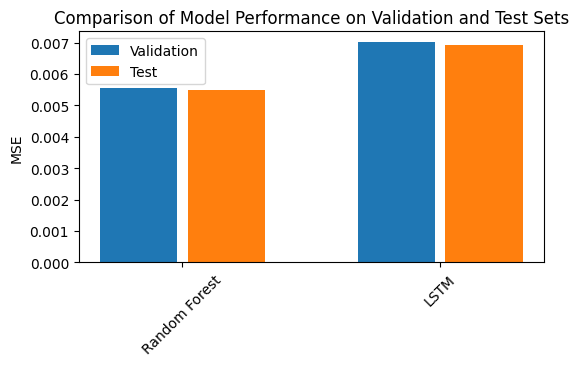

In [ ]:
# Compare the Mean Squared Error (MSE) for models

# Plot bar chart
plt.figure(figsize=(6, 3))
x = np.arange(2)
width = 0.3


plt.bar(x - 0.17, [mse_rf_val, mse_lstm_val], width, label='Validation')
plt.bar(x + 0.17, [mse_rf_test, mse_lstm_test], width, label='Test')
plt.xticks(ticks=x, labels=['Random Forest', 'LSTM'],
           rotation=45)
plt.ylabel('MSE')
plt.title('Comparison of Model Performance on Validation and Test Sets')
_ = plt.legend()
plt.show()



# 4. View the single and multiple steps prediction performance

## 4.1 Single prediction step

1/1 [==============================] - 0s 20ms/step


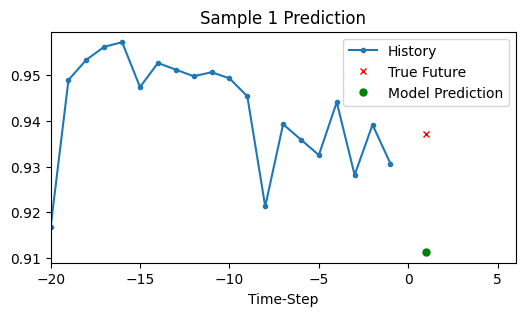

1/1 [==============================] - 0s 21ms/step


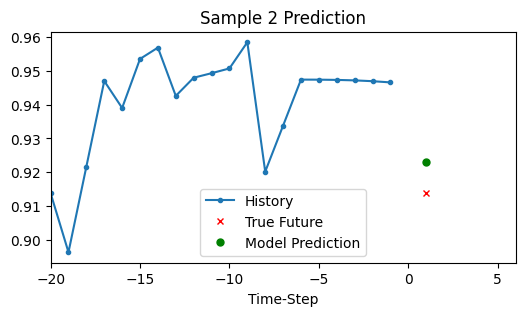

1/1 [==============================] - 0s 19ms/step


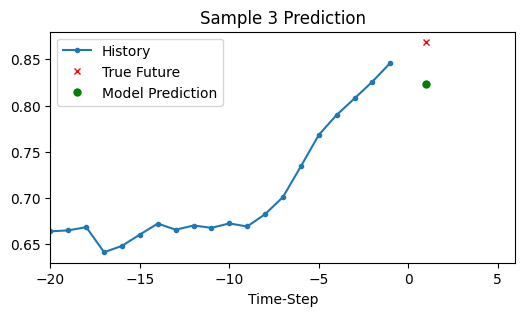

1/1 [==============================] - 0s 19ms/step


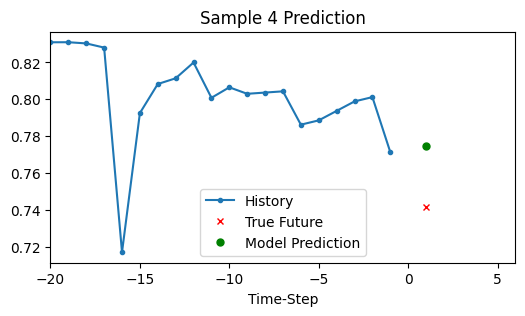

1/1 [==============================] - 0s 20ms/step


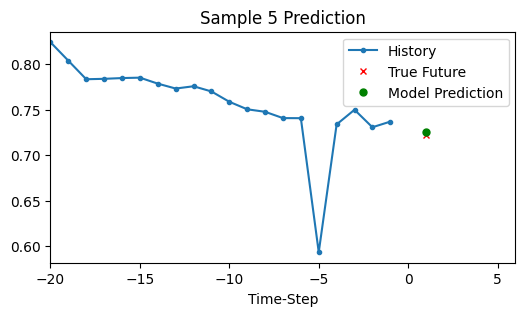

In [ ]:
# single step visualization 5 samples - LSTM/RF/convLSTM/randofrmer

# single step prediction 
def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = 1

    fig, ax = plt.subplots(figsize=(6, 3))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 2) * 2])
    plt.xlabel("Time-Step")
    plt.show()

# Prepare data for the plot
n = 5  # number of samples to visualize
random_indices = np.random.choice(len(X_test_avg), n, replace=False)

for i, idx in enumerate(random_indices):
    x_sample = X_test_avg[idx]
    y_sample = y_test_avg[idx]
    y_pred_lstm = lstm_model.predict(x_sample[np.newaxis, :, :])[0]

    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample
    model_prediction = y_pred_lstm

    show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1} Prediction")


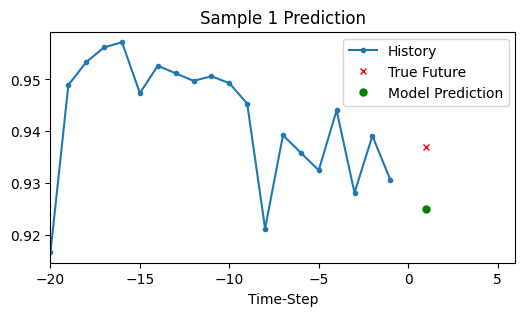

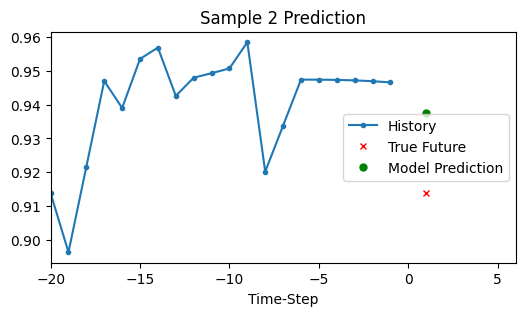

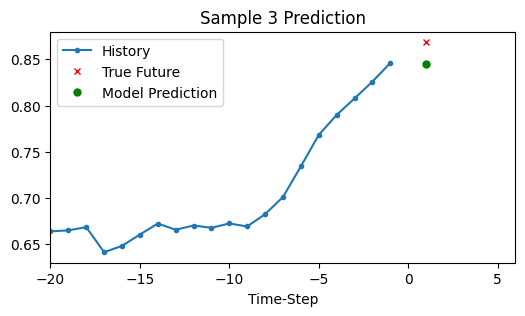

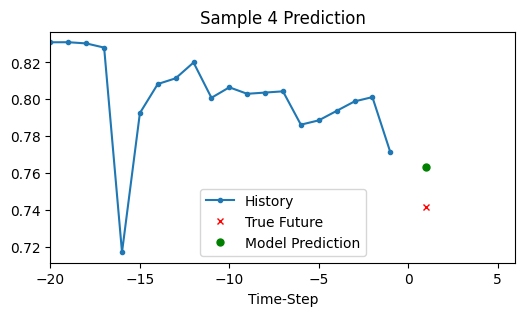

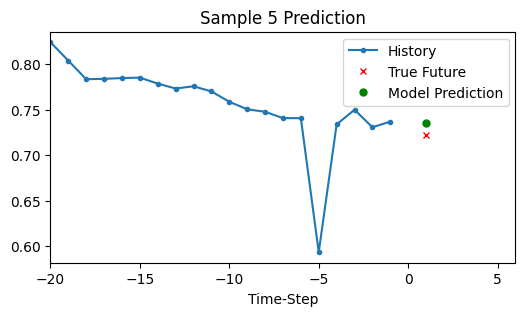

In [ ]:
# RF
#Single step prediction

for i, idx in enumerate(random_indices):
    x_sample = X_test_avg[idx]
    y_sample = y_test_avg[idx]
    y_pred_rf = rf_model.predict(x_sample.reshape(1, -1))[0] 

    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample
    model_prediction = y_pred_rf

    show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1} Prediction")

1/1 [==============================] - 0s 23ms/step


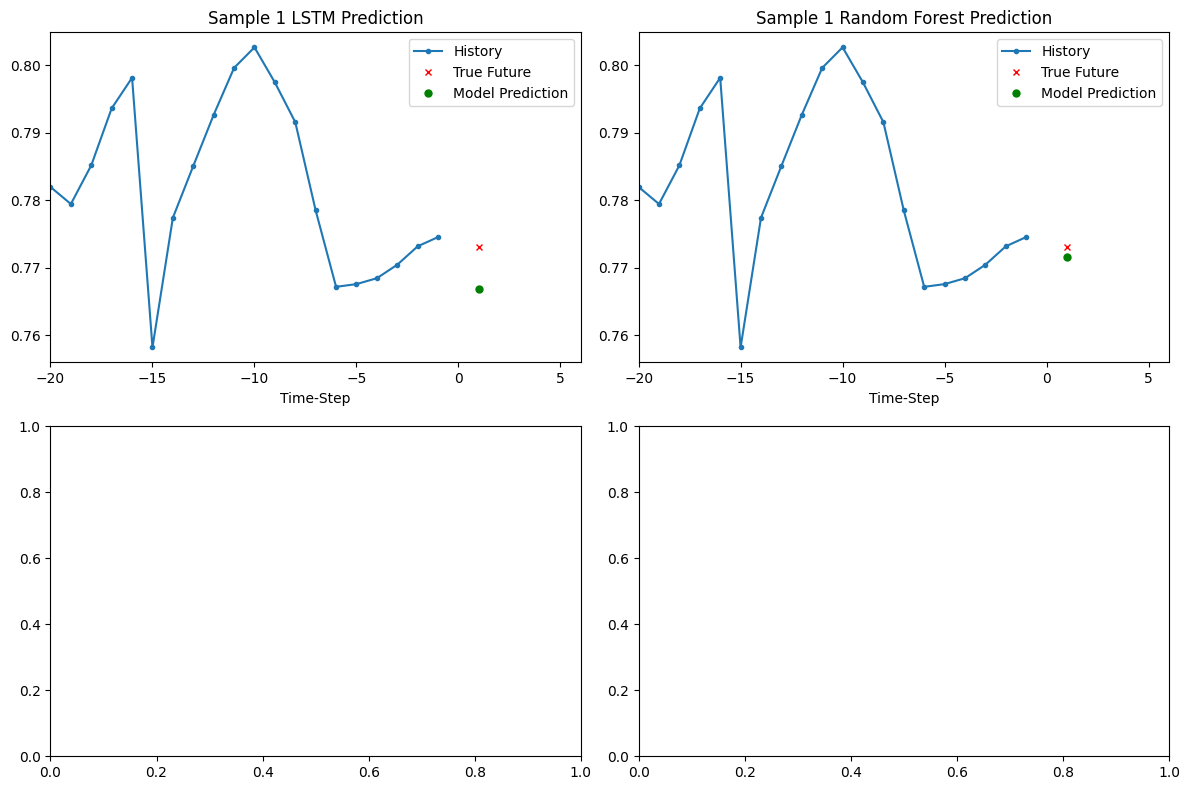

In [ ]:
# single step prediction for all models in one graph

def show_plot(plot_data, title, ax):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = 1

    ax.set_title(title)
    for i, val in enumerate(plot_data):
        if i:
            ax.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            ax.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    ax.legend()
    ax.set_xlim([time_steps[0], (future + 2) * 2])
    ax.set_xlabel("Time-Step")

# Prepare data for the plot
n = 1  # number of samples to visualize
random_indices = np.random.choice(len(X_test_avg), n, replace=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for i, idx in enumerate(random_indices):
    x_sample = X_test_avg[idx]
    y_sample = y_test_avg[idx]
    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample

    # LSTM
    y_pred_lstm = lstm_model.predict(x_sample[np.newaxis, :, :])[0]
    ax = axes[0, 0]
    show_plot([history_ndvi, true_future, y_pred_lstm], f"Sample {i + 1} LSTM Prediction", ax)

    # Random Forest
    y_pred_rf = rf_model.predict(x_sample.reshape(1, -1))[0]
    ax = axes[0, 1]
    show_plot([history_ndvi, true_future, y_pred_rf], f"Sample {i + 1} Random Forest Prediction", ax)

    # # ConvLSTM
    # x_sample_convlstm = x_sample[np.newaxis, :, np.newaxis, np.newaxis, :]
    # y_pred_convlstm = convlstm_model.predict(x_sample_convlstm)[0]
    # ax = axes[1, 0]
    # show_plot([history_ndvi, true_future, y_pred_convlstm], f"Sample {i + 1} ConvLSTM Prediction", ax)

    # # Transformer
    # y_pred_transformer = transformer_model.predict(x_sample[np.newaxis, :, :])[0]
    # ax = axes[1, 1]
    # show_plot([history_ndvi, true_future, y_pred_transformer], f"Sample {i + 1} Transformer Prediction", ax)

plt.tight_layout()
plt.show()


## 4.2 Multiple prediction steps

### predict 5 timesteps in the future

In [ ]:
# def predict_next_steps(model, input_sequence, num_steps):
#     predictions = []
#     current_input = input_sequence.copy()
#     for _ in range(num_steps):
#         current_input_reshaped = current_input.reshape(1, -1)
#         prediction = model.predict(current_input_reshaped)[0]
#         predictions.append(prediction)
#         current_input = np.roll(current_input, -1, axis=0)
#         current_input[-1, 0] = prediction
#     return np.array(predictions)

# def show_plot(plot_data, title):
#     labels = ["History", "True Future", "Model Prediction"]
#     marker = [".-", "rx", "go"]
#     time_steps = list(range(-(plot_data[0].shape[0]), 0))
#     future = np.arange(1, plot_data[1].shape[0] + 1)

#     fig, ax = plt.subplots(figsize=(8, 4))
#     plt.title(title)
#     for i, val in enumerate(plot_data):
#         if i:
#             plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
#         else:
#             plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
#     plt.legend()
#     plt.xlim([time_steps[0], future[-1] + 1])
#     plt.xlabel("Time-Step")
#     plt.show()

# # Prepare data for the plot
# n = 300  # number of samples to train on
# num_future_steps = 10  # Number of future steps to predict (from 21st to 30th)

# predicted_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the predicted NDVI values for all timesteps
# expected_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the expected NDVI values for all timesteps

# # Randomly select 5 indices from the test set for visualization
# n_visualize = 5
# random_indices = random.sample(range(n), n_visualize)

# for i in range(n):
#     x_sample = X_test_avg[i]
#     y_sample = y_test_avg[i:i+num_future_steps]

#     # Reshape y_sample to have two dimensions
#     y_sample = y_sample.reshape(-1, 1)

#     # Iterate over pixel IDs
#     for pixel_id in range(x_sample.shape[1]):
#         # Select data for the current pixel ID
#         x_pixel = x_sample[:, [pixel_id]]  # Use double brackets to preserve the shape
#         y_pixel = y_sample[:, 0]  # Indexing with 0 to remove the additional dimension

#         # Generate the 21st to 30th NDVI predictions for the current pixel ID
#         y_preds = predict_next_steps(rf_model, x_pixel, num_future_steps)

#         # Append the predicted NDVI values to the array
#         predicted_ndvi_all[i, :, pixel_id] = y_preds.flatten()
#         expected_ndvi_all[i, :, pixel_id] = y_pixel.flatten()

#         history_ndvi = x_pixel[:, 0]  # Select only NDVI_scaled from input_vars
#         true_future = y_pixel.flatten()
#         model_prediction = y_preds.flatten()

#         # If the current index is in the list of random indices, visualize the sample
#         if i in random_indices:
#             show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1}, Pixel {pixel_id + 1} Prediction")


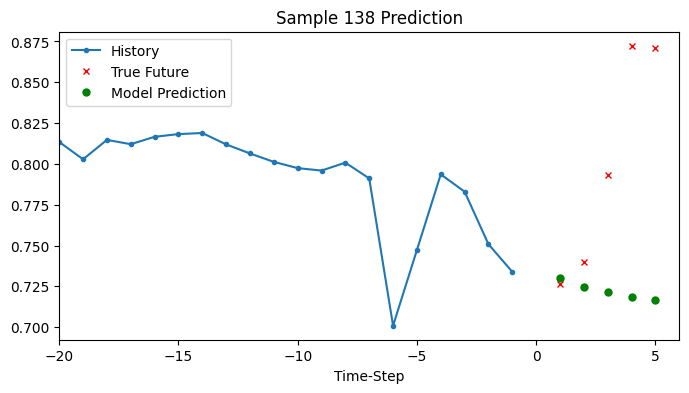

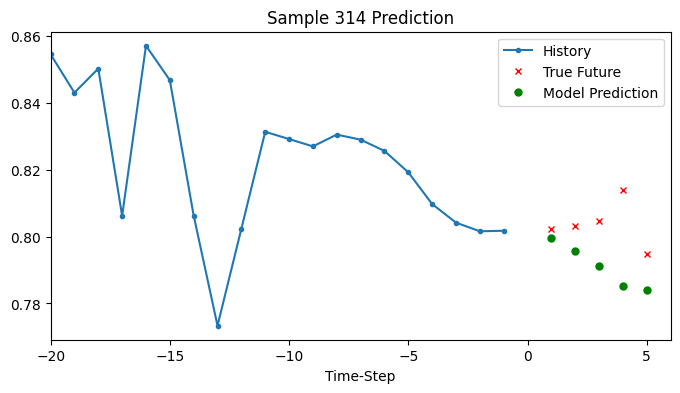

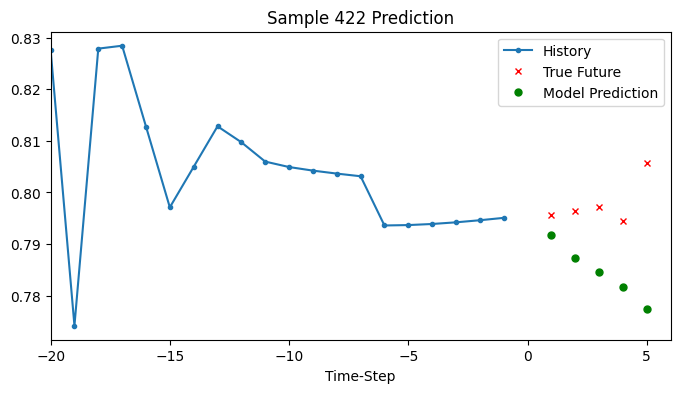

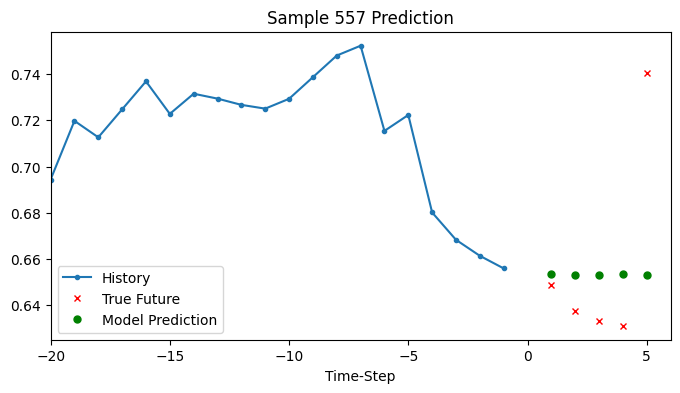

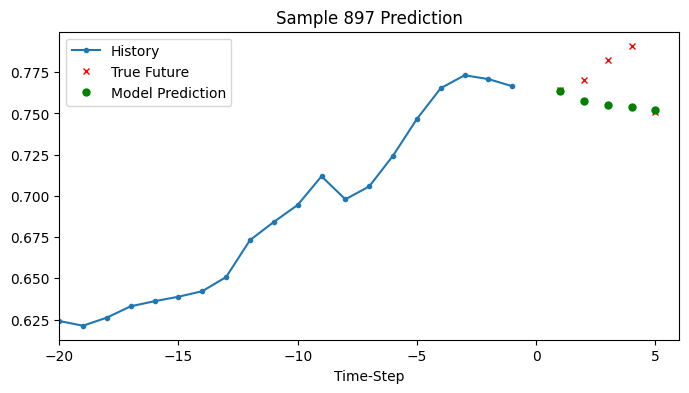

In [ ]:
# RFmodel - radomly 5 timesteps

def predict_next_steps(model, input_sequence, num_steps):
    predictions = []
    current_input = input_sequence.copy()
    for _ in range(num_steps):
        current_input_reshaped = current_input.reshape(1, -1)
        prediction = model.predict(current_input_reshaped)[0]
        predictions.append(prediction)
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction
    return np.array(predictions)

def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = np.arange(1, plot_data[1].shape[0] + 1)

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], future[-1] + 1])
    plt.xlabel("Time-Step")
    plt.show()

# Prepare data for the plot
n = 1000  # number of samples to train on
num_future_steps = 5  # Number of future steps to predict (from 21st to 30th)

predicted_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the predicted NDVI values for all timesteps
expected_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the expected NDVI values for all timesteps

# Randomly select 5 indices from the test set for visualization
n_visualize = 5
random_indices = random.sample(range(n), n_visualize)

for i in range(n):
    x_sample = X_test_avg[i]
    y_sample = y_test_avg[i : i + num_future_steps]

    # Generate the 21st to 30th NDVI predictions
    y_preds = predict_next_steps(rf_model, x_sample, num_future_steps)

    # Append the predicted NDVI values to the array
    predicted_ndvi_all[i, :] = y_preds.flatten()
    expected_ndvi_all[i, :] = y_sample.flatten()

    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample
    model_prediction = y_preds

    # If the current index is in the list of random indices, visualize the sample
    if i in random_indices:
        show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1} Prediction")


1/1 [==============================] - 0s 18ms/step


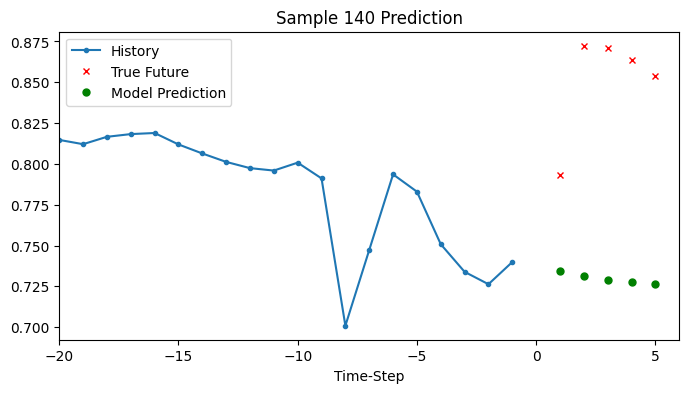

1/1 [==============================] - 0s 19ms/step


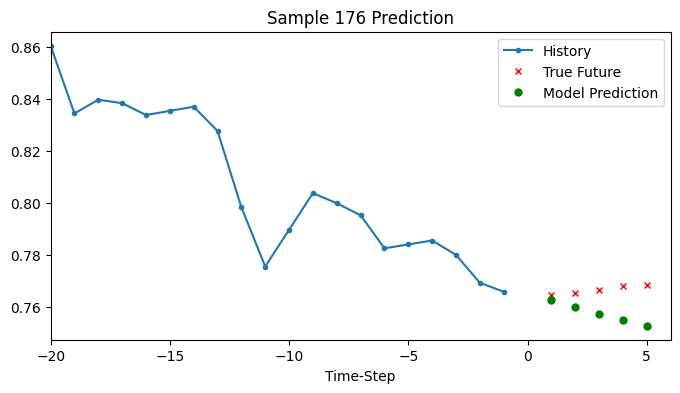

1/1 [==============================] - 0s 18ms/step


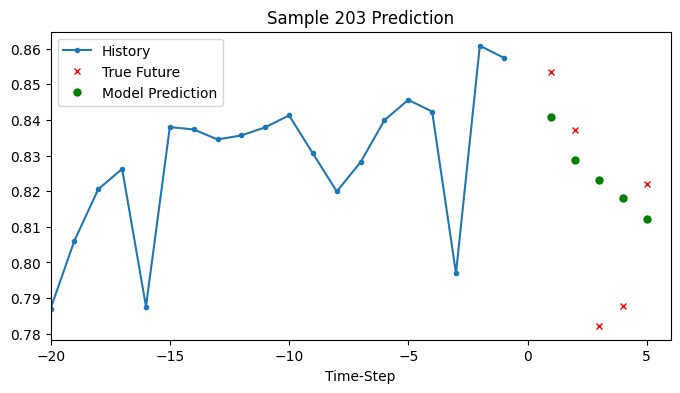

1/1 [==============================] - 0s 17ms/step


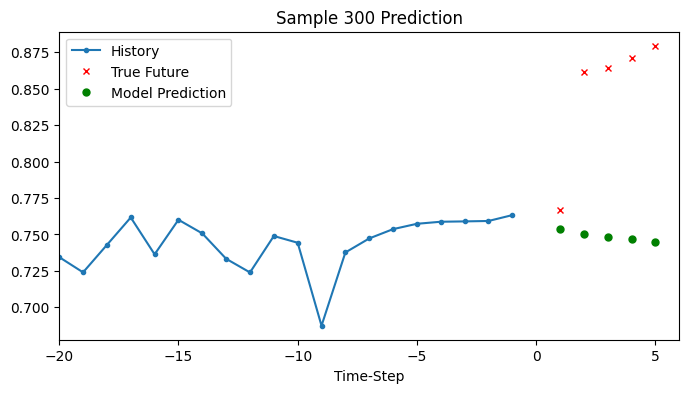

1/1 [==============================] - 0s 19ms/step


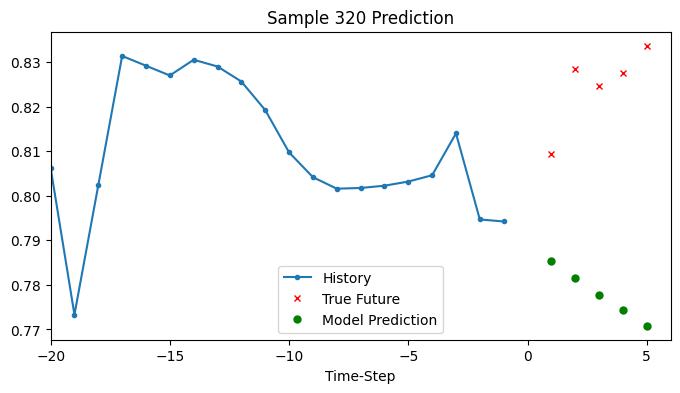

1/1 [==============================] - 0s 17ms/step


In [ ]:
# LSTM model - radomly 5 timesteps

import random

def predict_next_steps(model, input_sequence, num_steps):
    predictions = []
    current_input = input_sequence.copy()
    for _ in range(num_steps):
        current_input_reshaped = current_input[np.newaxis, :, :]
        prediction = model.predict(current_input_reshaped)[0]
        predictions.append(prediction)
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction
    return np.array(predictions)

def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = np.arange(1, plot_data[1].shape[0] + 1)

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], future[-1] + 1])
    plt.xlabel("Time-Step")
    plt.show()

# Prepare data for the plot
n = 1000  # number of samples to train on
num_future_steps = 5  # Number of future steps to predict (from 21st to 30th)

predicted_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the predicted NDVI values for all timesteps
expected_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the expected NDVI values for all timesteps

# Randomly select 5 indices from the test set for visualization
n_visualize = 5
random_indices = random.sample(range(n), n_visualize)

for i in range(n):
    x_sample = X_test_avg[i]
    y_sample = y_test_avg[i : i + num_future_steps]

    # Generate the 21st to 30th NDVI predictions
    y_preds = predict_next_steps(lstm_model, x_sample, num_future_steps)

    # Append the predicted NDVI values to the array
    predicted_ndvi_all[i, :] = y_preds.flatten()
    expected_ndvi_all[i, :] = y_sample.flatten()

    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample
    model_prediction = y_preds

    # If the current index is in the list of random indices, visualize the sample
    if i in random_indices:
        show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1} Prediction")


### predict 10 timesteps in the future

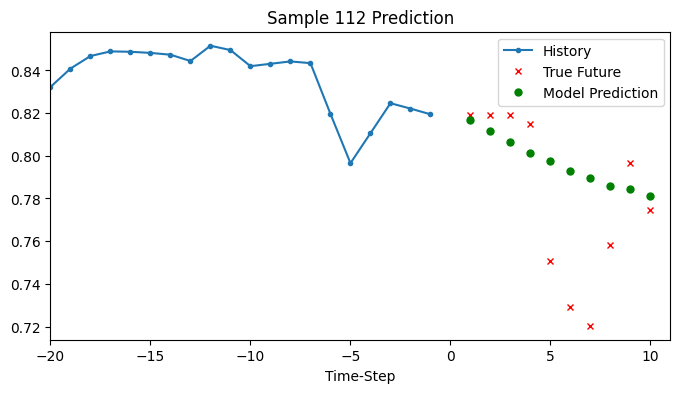

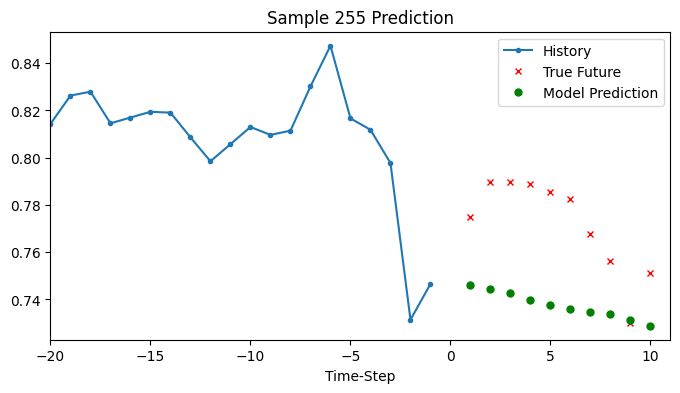

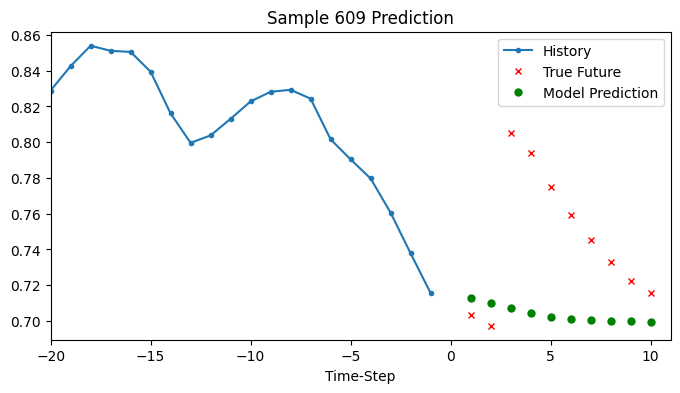

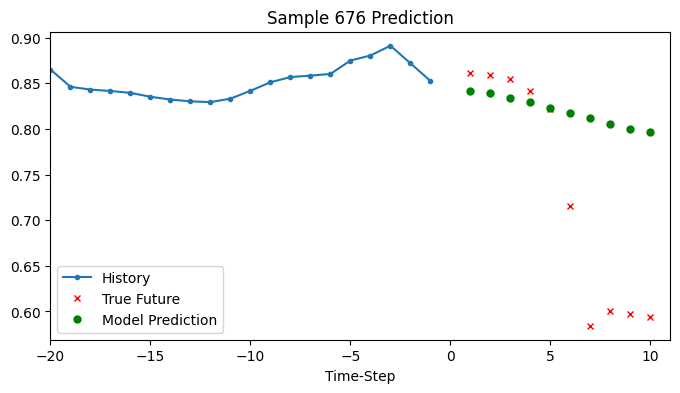

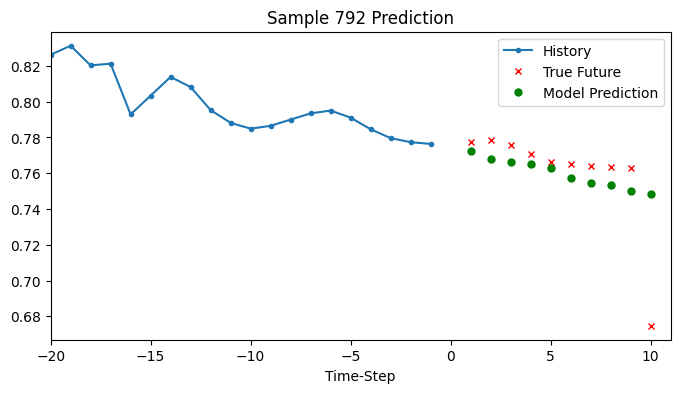

In [ ]:
# RFmodel - radomly 10 timesteps

def predict_next_steps(model, input_sequence, num_steps):
    predictions = []
    current_input = input_sequence.copy()
    for _ in range(num_steps):
        current_input_reshaped = current_input.reshape(1, -1)
        prediction = model.predict(current_input_reshaped)[0]
        predictions.append(prediction)
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction
    return np.array(predictions)

def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = np.arange(1, plot_data[1].shape[0] + 1)

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], future[-1] + 1])
    plt.xlabel("Time-Step")
    plt.show()

# Prepare data for the plot
n = 1000  # number of samples to train on
num_future_steps = 10  # Number of future steps to predict (from 21st to 30th)

predicted_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the predicted NDVI values for all timesteps
expected_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the expected NDVI values for all timesteps

# Randomly select 5 indices from the test set for visualization
n_visualize = 5
random_indices = random.sample(range(n), n_visualize)

for i in range(n):
    x_sample = X_test_avg[i]
    y_sample = y_test_avg[i : i + num_future_steps]

    # Generate the 21st to 30th NDVI predictions
    y_preds = predict_next_steps(rf_model, x_sample, num_future_steps)

    # Append the predicted NDVI values to the array
    predicted_ndvi_all[i, :] = y_preds.flatten()
    expected_ndvi_all[i, :] = y_sample.flatten()

    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample
    model_prediction = y_preds

    # If the current index is in the list of random indices, visualize the sample
    if i in random_indices:
        show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1} Prediction")


1/1 [==============================] - 0s 22ms/step


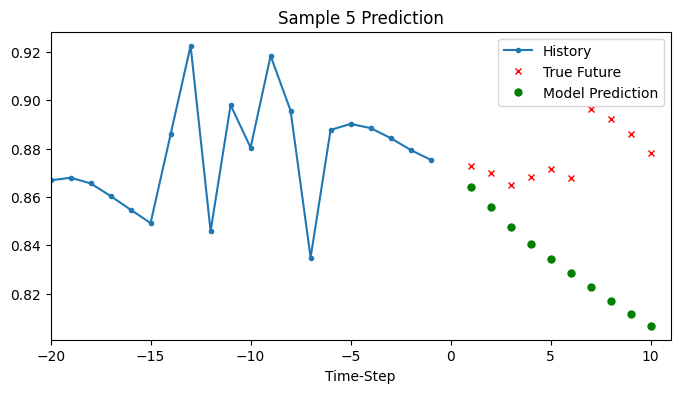

1/1 [==============================] - 0s 20ms/step


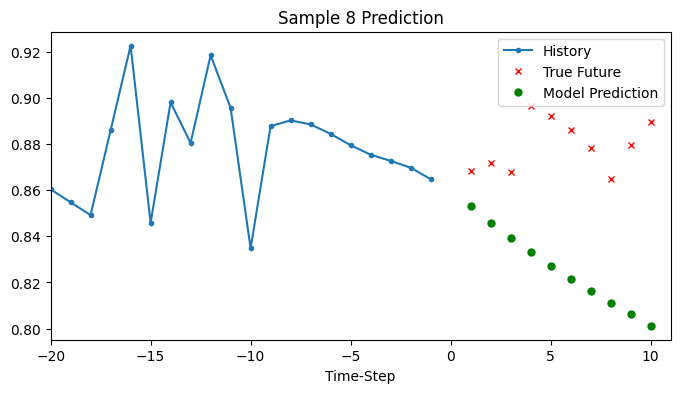

1/1 [==============================] - 0s 22ms/step


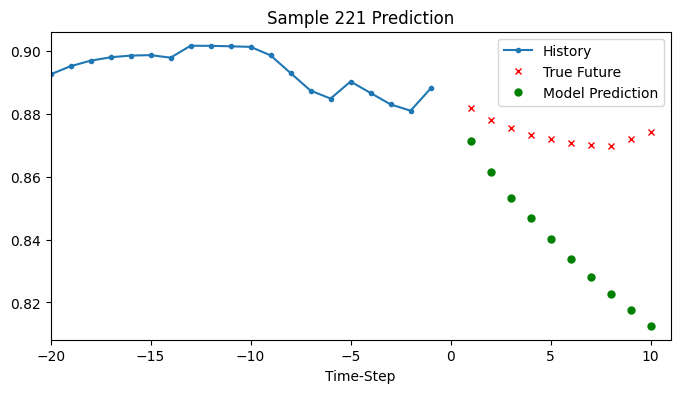

1/1 [==============================] - 0s 23ms/step


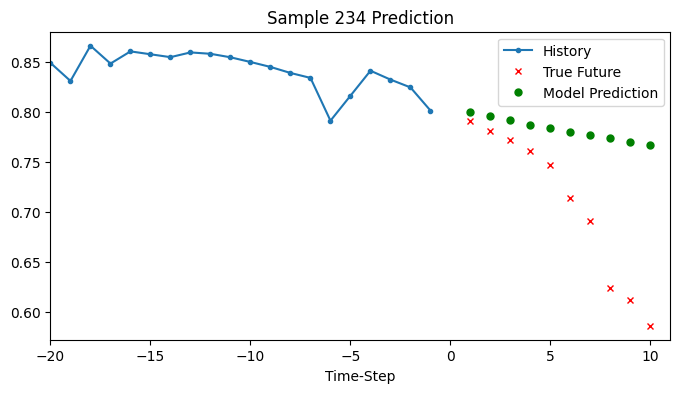

1/1 [==============================] - 0s 20ms/step


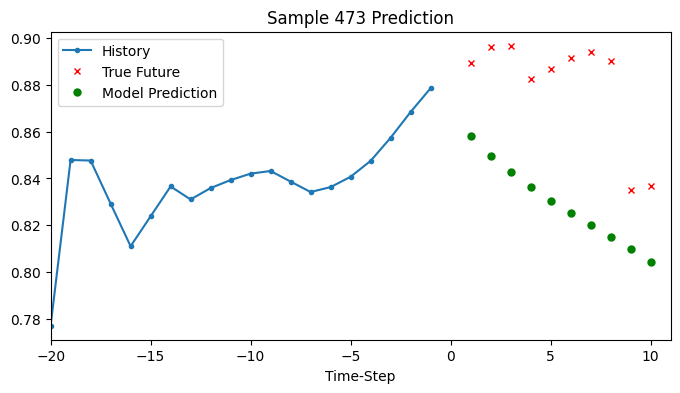

1/1 [==============================] - 0s 18ms/step


In [ ]:
# LSTM model - radomly 10 timesteps

import random

def predict_next_steps(model, input_sequence, num_steps):
    predictions = []
    current_input = input_sequence.copy()
    for _ in range(num_steps):
        current_input_reshaped = current_input[np.newaxis, :, :]
        prediction = model.predict(current_input_reshaped)[0]
        predictions.append(prediction)
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction
    return np.array(predictions)

def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = np.arange(1, plot_data[1].shape[0] + 1)

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], future[-1] + 1])
    plt.xlabel("Time-Step")
    plt.show()

# Prepare data for the plot
n = 500  # number of samples to train on
num_future_steps = 10  # Number of future steps to predict (from 21st to 30th)

predicted_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the predicted NDVI values for all timesteps
expected_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the expected NDVI values for all timesteps

# Randomly select 5 indices from the test set for visualization
n_visualize = 5
random_indices = random.sample(range(n), n_visualize)

for i in range(n):
    x_sample = X_test_avg[i]
    y_sample = y_test_avg[i : i + num_future_steps]

    # Generate the 21st to 30th NDVI predictions
    y_preds = predict_next_steps(lstm_model, x_sample, num_future_steps)

    # Append the predicted NDVI values to the array
    predicted_ndvi_all[i, :] = y_preds.flatten()
    expected_ndvi_all[i, :] = y_sample.flatten()

    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample
    model_prediction = y_preds

    # If the current index is in the list of random indices, visualize the sample
    if i in random_indices:
        show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1} Prediction")



## 4.3 View the prediction ability of models on different prediction timesteps

In [ ]:
#Cteate 2 dataframes for the model predicted NDVI and the correlated expected NDVI value
# RF

# Convert the NumPy arrays to pandas DataFrames
df_predicted = pd.DataFrame(data=predicted_ndvi_all, columns=["NDVI_t21", "NDVI_t22", "NDVI_t23", "NDVI_t24", "NDVI_t25", "NDVI_t26", "NDVI_t27", "NDVI_t28", "NDVI_t29", "NDVI_t30"])
df_expected = pd.DataFrame(data=expected_ndvi_all, columns=["NDVI_t21", "NDVI_t22", "NDVI_t23", "NDVI_t24", "NDVI_t25", "NDVI_t26", "NDVI_t27", "NDVI_t28", "NDVI_t29", "NDVI_t30"])

# Add index labels for each sequence
df_predicted.index = [f"Sequence {i+1}" for i in range(n)]
df_expected.index = [f"Sequence {i+1}" for i in range(n)]

# View the DataFrames
df_predicted



,NDVI_t21,NDVI_t22,NDVI_t23,NDVI_t24,NDVI_t25,NDVI_t26,NDVI_t27,NDVI_t28,NDVI_t29,NDVI_t30
Sequence 1,0.884424,0.878269,0.872922,0.866371,0.859348,0.855221,0.850028,0.845028,0.839835,0.837850
Sequence 2,0.881000,0.871341,0.862892,0.856591,0.848027,0.842037,0.837516,0.830414,0.823066,0.817193
Sequence 3,0.878467,0.873306,0.866588,0.860307,0.855382,0.850344,0.845577,0.840929,0.838251,0.832369
Sequence 4,0.873313,0.863217,0.857164,0.847703,0.841393,0.837662,0.830547,0.822893,0.816784,0.810998
Sequence 5,0.868911,0.866029,0.859994,0.855723,0.850225,0.845661,0.840849,0.838263,0.833028,0.827526
...,...,...,...,...,...,...,...,...,...,...
Sequence 996,0.704032,0.702040,0.700699,0.699849,0.699167,0.696048,0.694261,0.693999,0.693691,0.693601
Sequence 997,0.700852,0.699978,0.699294,0.696354,0.694249,0.694008,0.693821,0.693658,0.693566,0.693677
Sequence 998,0.701878,0.700746,0.699849,0.699132,0.696172,0.694318,0.693868,0.693774,0.693881,0.693776
Sequence 999,0.704807,0.702278,0.700853,0.700010,0.699348,0.696333,0.694303,0.694159,0.693846,0.693776


In [ ]:
df_expected

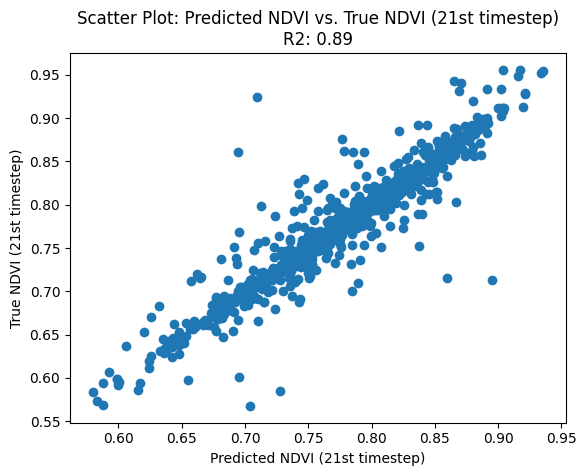

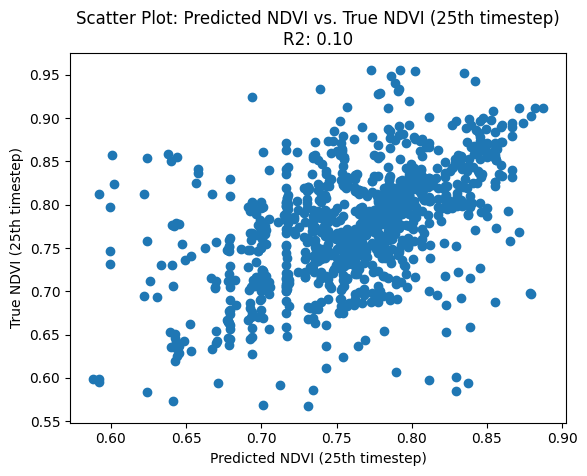

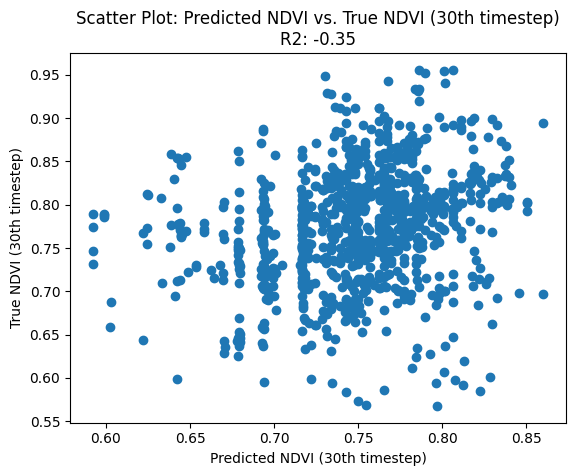

In [ ]:
# To view the correlation between predicted value and expected value in 1st, 5th and 10th timesteps

# Calculate R2 values
r2_21 = r2_score(df_expected["NDVI_t21"], df_predicted["NDVI_t21"])
r2_25 = r2_score(df_expected["NDVI_t25"], df_predicted["NDVI_t25"])
r2_30 = r2_score(df_expected["NDVI_t30"], df_predicted["NDVI_t30"])

# Plot scatter plot for timestep 21st
plt.scatter(df_predicted["NDVI_t21"], df_expected["NDVI_t21"])
plt.xlabel("Predicted NDVI (21st timestep)")
plt.ylabel("True NDVI (21st timestep)")
plt.title("Scatter Plot: Predicted NDVI vs. True NDVI (21st timestep)\nR2: {:.2f}".format(r2_21))
plt.show()

# Plot scatter plot for timestep 25th
plt.scatter(df_predicted["NDVI_t25"], df_expected["NDVI_t25"])
plt.xlabel("Predicted NDVI (25th timestep)")
plt.ylabel("True NDVI (25th timestep)")
plt.title("Scatter Plot: Predicted NDVI vs. True NDVI (25th timestep)\nR2: {:.2f}".format(r2_25))
plt.show()

# Plot scatter plot for timestep 30th
plt.scatter(df_predicted["NDVI_t30"], df_expected["NDVI_t30"])
plt.xlabel("Predicted NDVI (30th timestep)")
plt.ylabel("True NDVI (30th timestep)")
plt.title("Scatter Plot: Predicted NDVI vs. True NDVI (30th timestep)\nR2: {:.2f}".format(r2_30))
plt.show()


# Other models 